In [38]:
import logging
import numpy as np
import torch
from PIL import Image
from functools import lru_cache
from functools import partial
from itertools import repeat
from multiprocessing import Pool
from os import listdir
from os.path import splitext, isfile, join
from pathlib import Path
from torch.utils.data import Dataset
from tqdm import tqdm
import imageio
import matplotlib.image as mpimg
import tifffile
from torch import nn
import torchvision
from torchvision.transforms import v2
from torchvision import transforms
import torchvision.transforms.functional as TF
import random
from utils import *
from datasets import *
import torch.nn.functional as Func
import torch
import datasets

In [39]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap([[0.29411764705882354, 0.4392156862745098, 0.7333333333333333],
                        [0.5882352941176471, 0.7607843137254902, 0.8666666666666667],
                        [0.8901960784313725, 0.9647058823529412, 0.9764705882352941],
                        [0.9803921568627451, 0.8745098039215686, 0.4666666666666667],
                        [0.9607843137254902, 0.47058823529411764, 0.29411764705882354],
                        [0.8470588235294118, 0.1568627450980392, 0.1411764705882353]]
                            )

In [40]:
import math

def calculate_window_positions(image_width, image_height, window_size, step_size):
    window_positions = []

    # Calculate the number of passes in horizontal and vertical directions
    horizontal_passes = math.floor((image_width - window_size) / step_size) + 1
    vertical_passes = math.floor((image_height - window_size) / step_size) + 1

    # Iterate over each pass
    for i in range(vertical_passes):
        for j in range(horizontal_passes):
            # Calculate the initial position of the window
            start_x = j * step_size
            start_y = i * step_size

            # Calculate the final position of the window
            end_x = start_x + window_size
            end_y = start_y + window_size

            # window_positions.append(((start_x, start_y), (end_x, end_y)))
            window_positions.append((start_x, start_y))

    return window_positions

In [41]:
data_filename = "data/images/train/"
mask_filename = "data/annotations/train/"

In [42]:
file = "il_0"

teste = get_input_data(data_filename + file + ".tif")
mask = load_image(mask_filename + file + ".png")

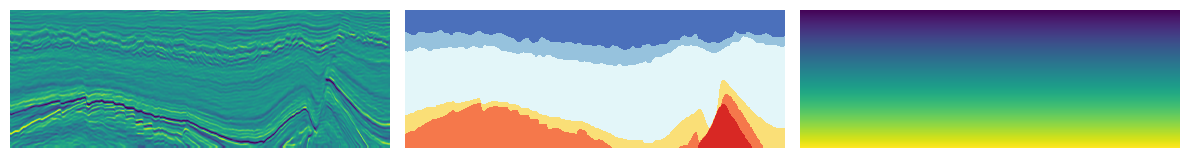

In [43]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(teste[:,:,0])
axs[1].imshow(mask, cmap=cmap)
axs[2].imshow(teste[:,:,1])

# Remove the axis labels
for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [44]:
data_dir = "data/images/train"
mask_dir = "data/annotations/train"

dataset = BasicDataset(data_dir=data_dir, mask_dir=mask_dir, augmentation=True) 

100%|██████████| 1102/1102 [00:00<00:00, 2958.08it/s]


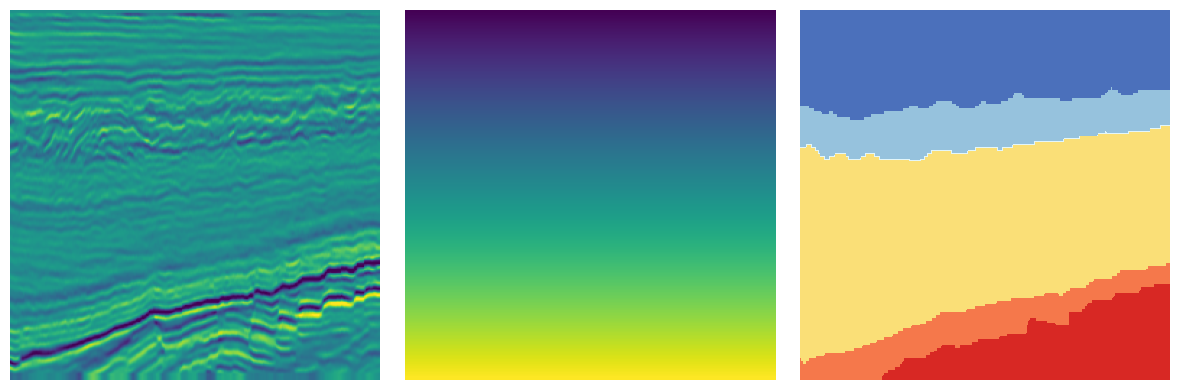

In [45]:
idx = random.randint(0, len(dataset))

instancia = dataset[idx]

data_teste, mask_teste = instancia['image'], instancia['mask']

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(data_teste[0,:,:])
axs[1].imshow(data_teste[1,:,:])
axs[2].imshow(mask_teste, cmap=cmap)

# Remove the axis labels
for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [46]:
from torch.utils.data import DataLoader
import os

In [47]:
train_dir = 'data/images/train'
train_mask_dir = 'data/annotations/train'
val_dir = 'data/images/val'
val_mask_dir = 'data/annotations/val'
checkpoint_dir = 'checkpoints/'

In [48]:
loader_args = dict(batch_size = 16, num_workers = os.cpu_count(), pin_memory = True)
train_loader = DataLoader(dataset, shuffle = True, **loader_args)

In [49]:
len(train_loader)

69

In [50]:
first_batch = next(iter(train_loader))
len(first_batch)

2

In [51]:
element1 = first_batch['image']
element2 = first_batch['mask']
element1.shape, element2.shape

(torch.Size([16, 2, 256, 256]), torch.Size([16, 256, 256]))

In [52]:
from pathlib import Path

data_dir = Path("data/images/train/")
mask_filename = Path("data/annotations/train/")

In [53]:
ids = set([splitext(file)[0] for file in listdir(data_dir) if isfile(join(data_dir, file)) and not file.startswith('.')])
ids

{'xl_618',
 'xl_44',
 'il_242',
 'xl_214',
 'xl_418',
 'xl_567',
 'il_381',
 'xl_601',
 'il_153',
 'xl_10',
 'il_216',
 'xl_198',
 'il_196',
 'il_4',
 'il_329',
 'xl_631',
 'xl_242',
 'il_167',
 'xl_626',
 'xl_264',
 'xl_515',
 'xl_283',
 'xl_190',
 'il_25',
 'il_276',
 'xl_633',
 'xl_395',
 'il_152',
 'il_271',
 'il_394',
 'xl_119',
 'il_75',
 'il_294',
 'xl_526',
 'il_338',
 'xl_275',
 'xl_40',
 'il_220',
 'xl_524',
 'il_313',
 'il_164',
 'xl_13',
 'il_229',
 'il_379',
 'xl_614',
 'xl_534',
 'xl_692',
 'xl_169',
 'il_186',
 'xl_223',
 'xl_463',
 'il_200',
 'xl_502',
 'xl_497',
 'xl_662',
 'xl_569',
 'il_204',
 'il_372',
 'xl_269',
 'il_291',
 'xl_421',
 'il_333',
 'xl_259',
 'xl_472',
 'xl_465',
 'xl_29',
 'xl_330',
 'xl_191',
 'xl_427',
 'xl_376',
 'xl_28',
 'xl_460',
 'il_279',
 'il_205',
 'xl_492',
 'il_31',
 'xl_598',
 'il_202',
 'xl_231',
 'xl_480',
 'xl_180',
 'il_147',
 'xl_294',
 'il_22',
 'xl_612',
 'xl_304',
 'xl_394',
 'xl_14',
 'xl_143',
 'il_62',
 'il_163',
 'xl_445',
 '

In [54]:
def contar_prefixos(lista):
    contagem = {}
    for elemento in lista:
        prefixo = elemento[:2]
        if prefixo in contagem:
            contagem[prefixo] += 1
        else:
            contagem[prefixo] = 1
    return contagem

cont = contar_prefixos(ids)
print(cont)

splits = 5
splits_list = []

for i in cont:
    num = cont[i] // splits
    splits_list.append(num)

list = [[],[]]
print(splits_list)

for j in splits_list:
    for i in range(splits):
        print(*range(j*i, j*(i+1), 1))
        
        



{'xl': 701, 'il': 401}
[140, 80]
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 2

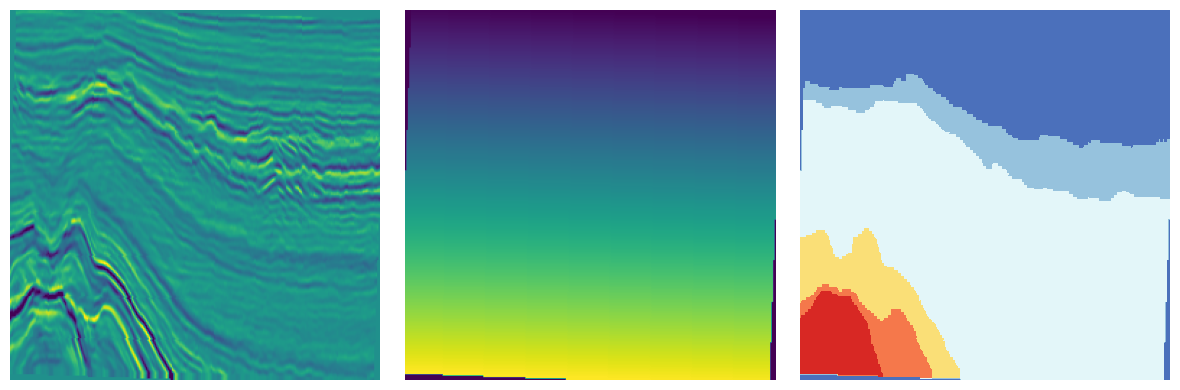

In [18]:
idx = random.randint(0, 16)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(element1[idx][0])
axs[1].imshow(element1[idx][1])
axs[2].imshow(element2[idx], cmap=cmap)

# Remove the axis labels
for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [19]:
from datasets import *

In [20]:
dataset_no_transform = BasicDataset(data_dir=data_dir, mask_dir=mask_dir, augmentation=False)

 25%|██▌       | 278/1102 [00:00<00:00, 2768.59it/s]

100%|██████████| 1102/1102 [00:00<00:00, 2989.33it/s]


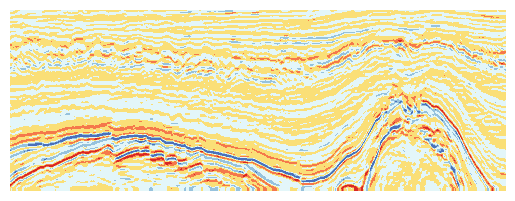

In [21]:
from torchvision.transforms import functional as F

idx = random.randint(0, len(dataset_no_transform)-1)
instancia_no_transform = dataset_no_transform[idx]
image = instancia_no_transform['image']

i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(256, 256))
# image = TF.crop(image, i, j, h, w)
i, j, h, w

plt.imshow(image[0], cmap=cmap)
plt.axis('off')
plt.show()

In [22]:
# image = torch.rand(1, 256, 701)

In [23]:
image.shape

torch.Size([2, 256, 701])

In [24]:
image = TF.pad(image, padding=(128, 0, 128, 0), padding_mode='reflect')

In [25]:
image.shape

torch.Size([2, 256, 957])

In [26]:
image_width = image.shape[2]
image_height = image.shape[1]
window_size = 256
step_size = 32

window_positions = calculate_window_positions(image_width, image_height, window_size, step_size)
image_height, image_width

(256, 957)

In [27]:
from torchvision.transforms import functional as TF


crops = []
patch_size = 256

for (x, y) in window_positions:
    crop = image[:, y:y+patch_size, x:x+patch_size]
    crops.append(crop)


crops[0].shape, image.shape

(torch.Size([2, 256, 256]), torch.Size([2, 256, 957]))

In [28]:
len(crops)

22

torch.Size([2, 256, 957])

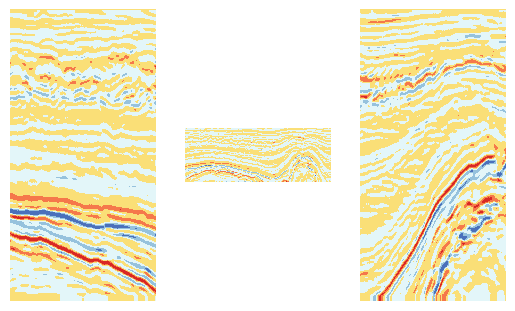

In [29]:
fig, axs = plt.subplots(1, 3)

axs[0].imshow(image[0, :, :128], cmap=cmap)
axs[0].axis('off')

axs[1].imshow(image[0, :, 128:701+128], cmap=cmap)
axs[1].axis('off')

axs[2].imshow(image[0, :, 701+128:], cmap=cmap)
axs[2].axis('off')

image.shape

(-0.5, 956.5, 255.5, -0.5)

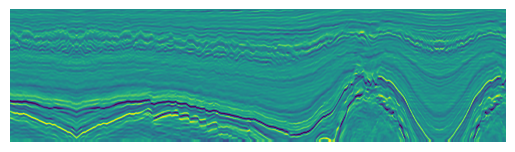

In [30]:
# plt.imshow(image[0], cmap=cmap)
plt.imshow(image[0])
plt.axis('off')

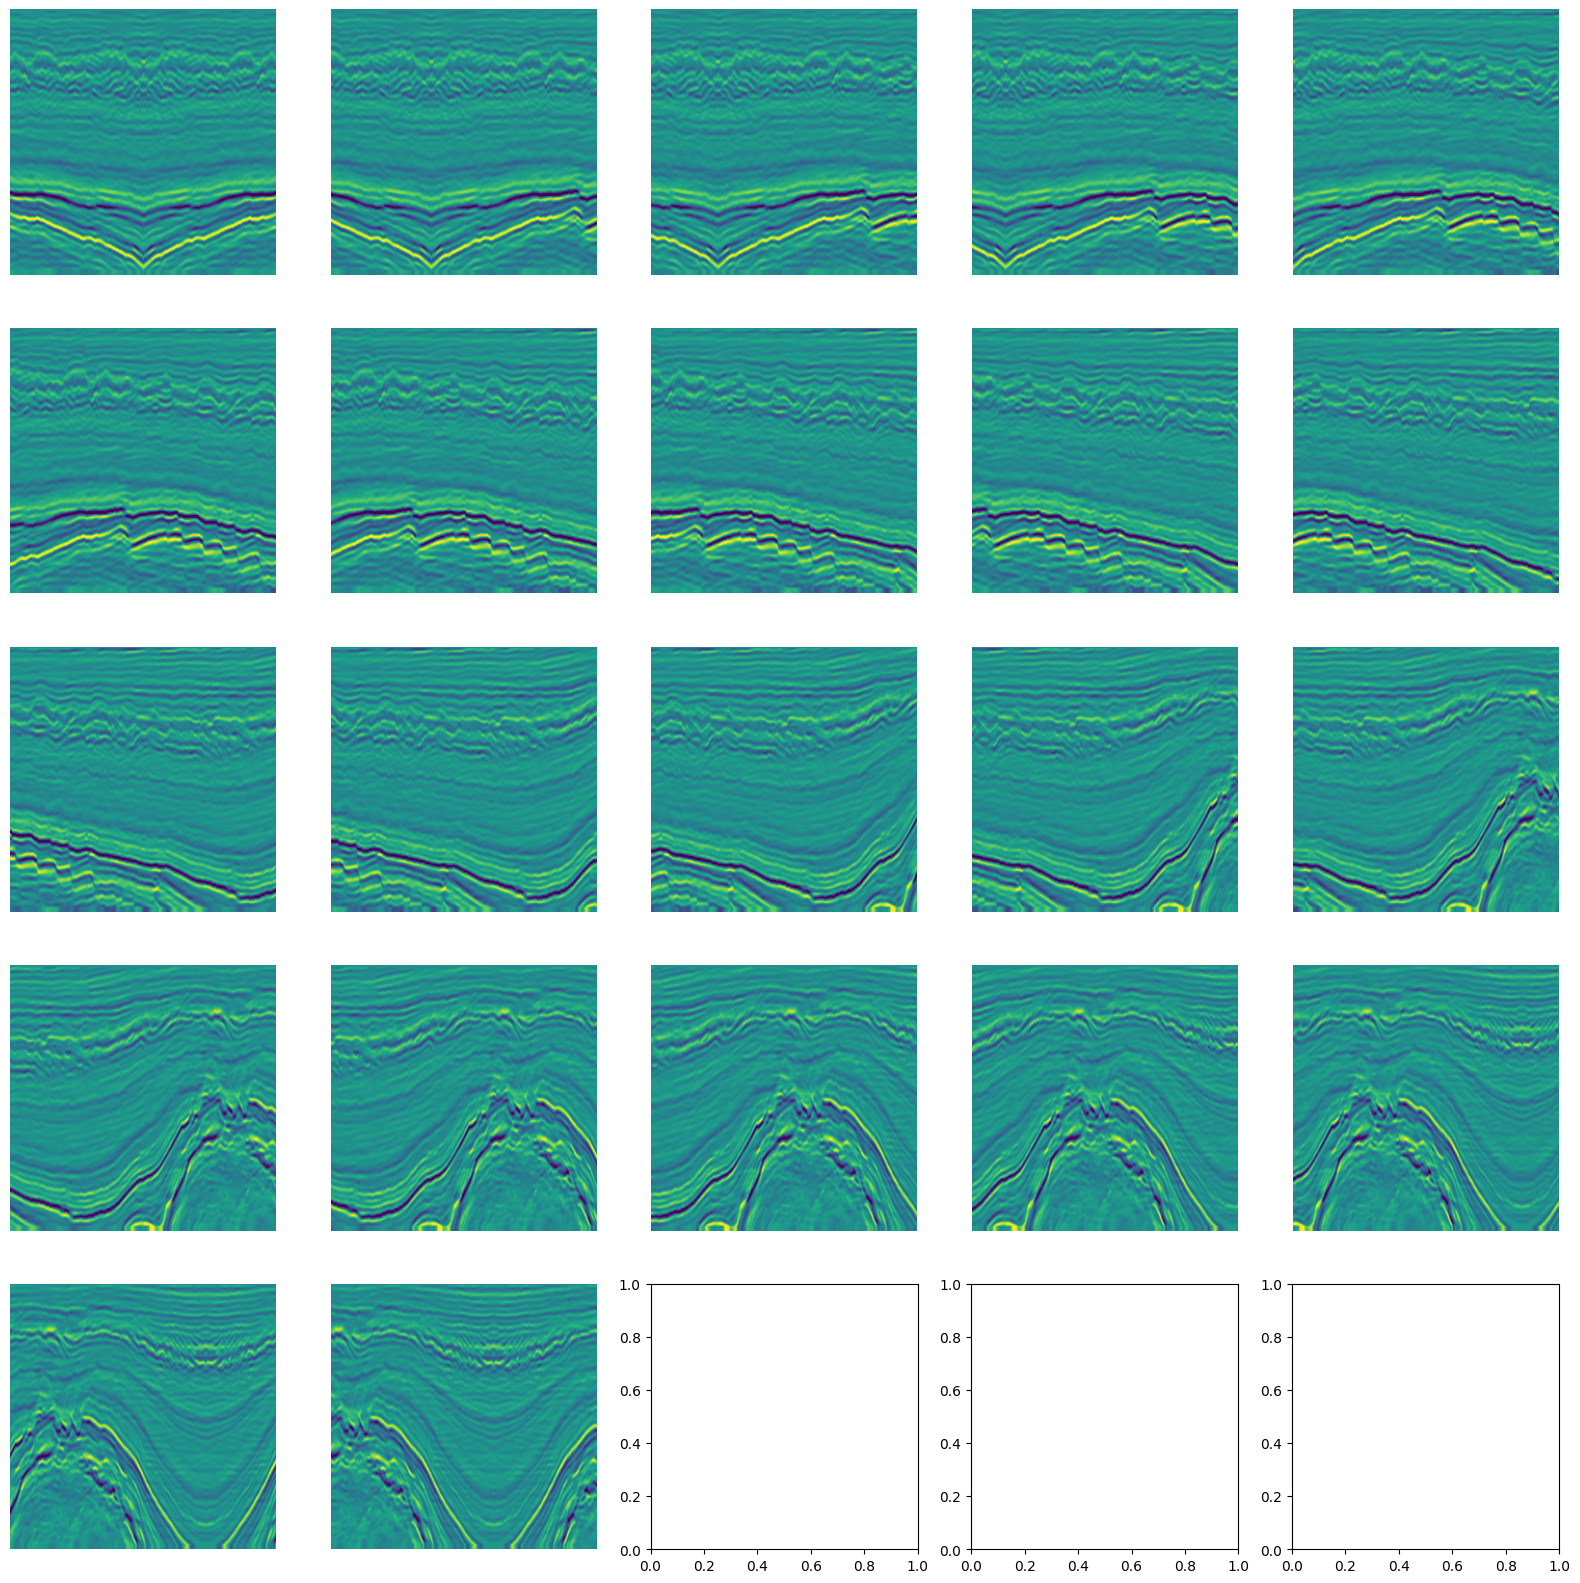

In [31]:
num_cols = 5
num_rols = int(np.ceil(len(crops)/num_cols))

fix, axs = plt.subplots(num_rols, num_cols, figsize=(20, 20))

for i, crop in enumerate(crops):
    row = i // num_cols
    col = i % num_cols
    # axs[row, col].imshow(crop[0], cmap=cmap)
    axs[row, col].imshow(crop[0])
    axs[row, col].axis('off')

# plt.tight_layout()


In [32]:
mask.shape

(255, 701)

In [33]:
mask_values = [0, 1, 2, 3, 4, 5]

In [34]:
image

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0179,  0.0158,  0.0178,  ..., -0.0030, -0.0073, -0.0062],
         [ 0.0718,  0.0620,  0.0747,  ...,  0.0070, -0.0164, -0.0090],
         ...,
         [ 0.1976,  0.2007,  0.1721,  ..., -0.1319, -0.0376,  0.0847],
         [ 0.1976,  0.2007,  0.1721,  ..., -0.1319, -0.0376,  0.0847],
         [ 0.1976,  0.2007,  0.1721,  ..., -0.1319, -0.0376,  0.0847]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0039,  0.0039,  0.0039,  ...,  0.0039,  0.0039,  0.0039],
         [ 0.0079,  0.0079,  0.0079,  ...,  0.0079,  0.0079,  0.0079],
         ...,
         [ 0.9961,  0.9961,  0.9961,  ...,  0.9961,  0.9961,  0.9961],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]]],
       dtype=torch.float64)

In [35]:
# tensor_mask = torch.from_numpy(image)
tensor_mask = image
tensor_mask.shape

torch.Size([2, 256, 957])

In [36]:
mask_teste = Func.one_hot(tensor_mask.to(torch.int64), len(mask_values))

RuntimeError: Class values must be non-negative.

In [ ]:
# mask_teste = mask_teste.permute(2, 0, 1)
mask_teste = mask_teste.permute(0, 3, 1, 2)
mask_teste.shape

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4

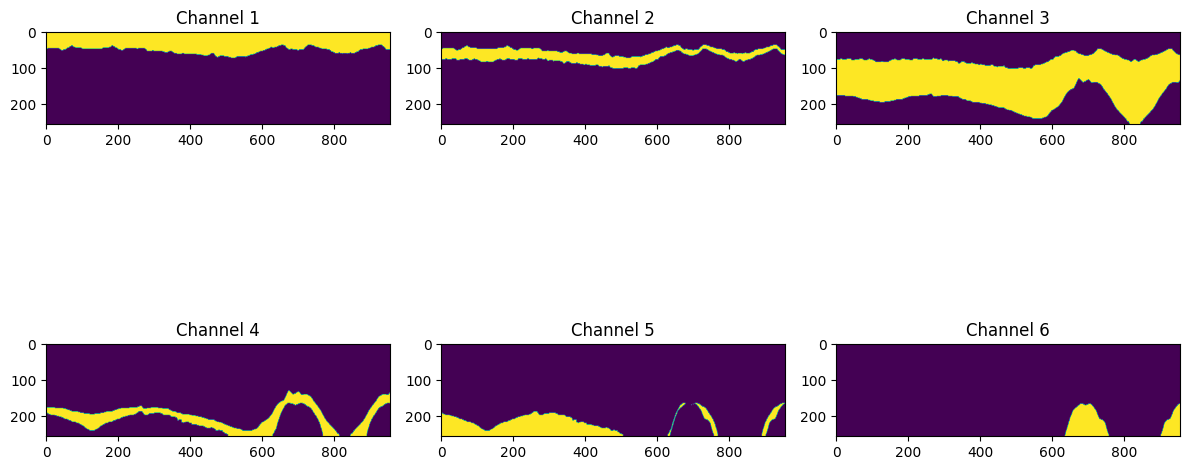

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()
for i, channel in enumerate(mask_teste[0]):
    axs[i].imshow(channel)
    axs[i].set_title(f'Channel {i+1}')
plt.tight_layout()
plt.show()


In [ ]:
def reconstruct_image(list_coords, list_images, n_classes, out_height, out_width):
    
    image_size = list_images[0].shape[1]
    out_image = np.zeros((out_height, out_width, n_classes))
    
    for i, (x, y) in enumerate(list_coords):
        temp = Func.one_hot(torch.tensor(list_images[i]).to(torch.int64), n_classes)
        aux = np.add(out_image[y:y+image_size, x:x+image_size], temp)
        out_image[y:y+image_size, x:x+image_size] = aux
        
    return torch.from_numpy(out_image.transpose(2, 0, 1))

In [ ]:
out_image = reconstruct_image(window_positions, crops, 6, image_height, image_width)
out_image.argmax(0)

C:\Users\vilem\AppData\Local\Temp\ipykernel_13888\1415803397.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp = Func.one_hot(torch.tensor(list_images[i]).to(torch.int64), n_classes)


tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [4, 4, 4,  ..., 0, 0, 0],
        [4, 4, 4,  ..., 0, 0, 0],
        [4, 4, 4,  ..., 0, 0, 0]])

(<matplotlib.image.AxesImage at 0x29829d758a0>, torch.Size([256, 701]))

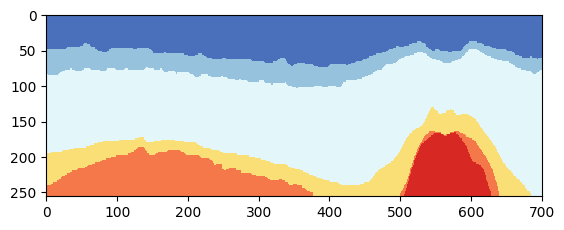

In [ ]:
out_image_cropped = out_image.argmax(0)[:,128:-128]
plt.imshow(out_image_cropped, cmap=cmap), out_image_cropped.shape

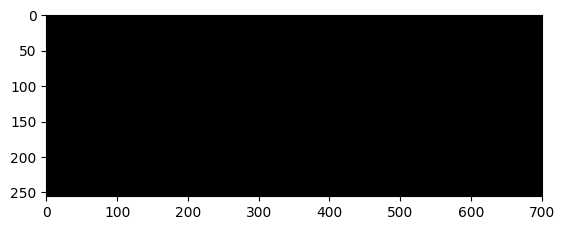

In [ ]:
image_cropped = image[0,:,128:701+128]
plt.imshow(out_image_cropped - image_cropped, cmap='gray')


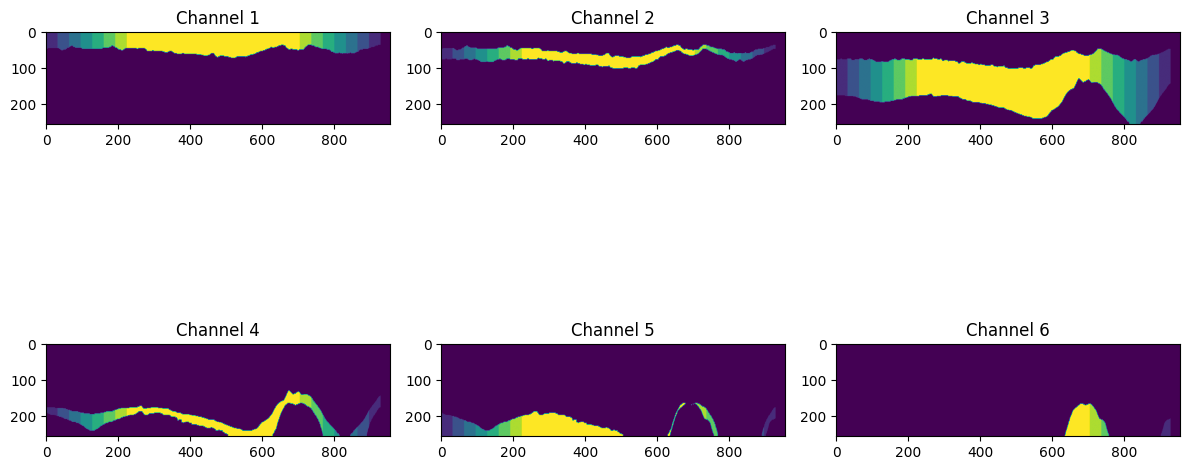

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()
for i, channel in enumerate(out_image):
    axs[i].imshow(channel)
    axs[i].set_title(f'Channel {i+1}')
plt.tight_layout()
plt.show()
